In [191]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fftn, fftshift
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter

In [290]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW")
fileName ='shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5'
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')

In [291]:
psi = 0

In [292]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
eta = f.get('eta')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)
eta = np.array(eta)

In [293]:
dx = 7.5 
dy = 7.5
dt = 1

In [6]:
maxFrequency = 4.0 
# Approximate max  frequency to consider (converted to max wavenumber below) [rad/sec]

dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))
# % wavenumber resolution of spectrum in each spatial window 
# (not strictly true if dx ~= dy, but value only needs to be approximate in practice)

kW = 1*dk
# Half width of wavenumbers bins [rad/m]

dk

0.012503851357571316

In [7]:
wavenumbers = np.arange(3 * dk, 0.305, dk)

In [8]:
wavenumbers

array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
       0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
       0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
       0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
       0.28758858, 0.30009243])

In [9]:
Nt, Nx, Ny = eta.shape

In [10]:
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values

In [11]:
dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

In [12]:
Norm = dKx*dKy*dW

In [13]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [14]:
power_Spectrum.shape

(1200, 67, 67)

In [51]:
g = 9.81
h = 1000

def w_dr(kx, ky, Ux, Uy):
    return np.sqrt(g * np.sqrt( kx **2 + ky **2 ) * np.tanh(h * np.sqrt( kx **2 + ky **2 ))) + kx * Ux + ky * Uy

In [16]:
from matplotlib.colors import ListedColormap

In [223]:
%matplotlib widget
# makes plots interactive

In [240]:
%matplotlib inline

In [17]:
Uk[:,0].shape

(680,)

In [18]:
Uk

array([[0.05494615, 0.05494615, 0.05494615, ..., 0.05494615, 0.05494615,
        0.05494615],
       [0.05745544, 0.05745544, 0.05745544, ..., 0.05745544, 0.05745544,
        0.05745544],
       [0.05994452, 0.05994452, 0.05994452, ..., 0.05994452, 0.05994452,
        0.05994452],
       ...,
       [0.63260879, 0.63260879, 0.63260879, ..., 0.63260879, 0.63260879,
        0.63260879],
       [0.63295845, 0.63295845, 0.63295845, ..., 0.63295845, 0.63295845,
        0.63295845],
       [0.63330752, 0.63330752, 0.63330752, ..., 0.63330752, 0.63330752,
        0.63330752]])

In [19]:
k

array([0.01  , 0.0105, 0.011 , 0.0115, 0.012 , 0.0125, 0.013 , 0.0135,
       0.014 , 0.0145, 0.015 , 0.0155, 0.016 , 0.0165, 0.017 , 0.0175,
       0.018 , 0.0185, 0.019 , 0.0195, 0.02  , 0.0205, 0.021 , 0.0215,
       0.022 , 0.0225, 0.023 , 0.0235, 0.024 , 0.0245, 0.025 , 0.0255,
       0.026 , 0.0265, 0.027 , 0.0275, 0.028 , 0.0285, 0.029 , 0.0295,
       0.03  , 0.0305, 0.031 , 0.0315, 0.032 , 0.0325, 0.033 , 0.0335,
       0.034 , 0.0345, 0.035 , 0.0355, 0.036 , 0.0365, 0.037 , 0.0375,
       0.038 , 0.0385, 0.039 , 0.0395, 0.04  , 0.0405, 0.041 , 0.0415,
       0.042 , 0.0425, 0.043 , 0.0435, 0.044 , 0.0445, 0.045 , 0.0455,
       0.046 , 0.0465, 0.047 , 0.0475, 0.048 , 0.0485, 0.049 , 0.0495,
       0.05  , 0.0505, 0.051 , 0.0515, 0.052 , 0.0525, 0.053 , 0.0535,
       0.054 , 0.0545, 0.055 , 0.0555, 0.056 , 0.0565, 0.057 , 0.0575,
       0.058 , 0.0585, 0.059 , 0.0595, 0.06  , 0.0605, 0.061 , 0.0615,
       0.062 , 0.0625, 0.063 , 0.0635, 0.064 , 0.0645, 0.065 , 0.0655,
      

In [85]:
np.sqrt(kx**2+ky**2) 

array([[0.58354283, 0.57476928, 0.56613595, ..., 0.56613595, 0.57476928,
        0.58354283],
       [0.57476928, 0.56585972, 0.55708833, ..., 0.55708833, 0.56585972,
        0.57476928],
       [0.56613595, 0.55708833, 0.5481766 , ..., 0.5481766 , 0.55708833,
        0.56613595],
       ...,
       [0.56613595, 0.55708833, 0.5481766 , ..., 0.5481766 , 0.55708833,
        0.56613595],
       [0.57476928, 0.56585972, 0.55708833, ..., 0.55708833, 0.56585972,
        0.57476928],
       [0.58354283, 0.57476928, 0.56613595, ..., 0.56613595, 0.57476928,
        0.58354283]])

In [49]:
w_values.shape

(680, 67, 67)

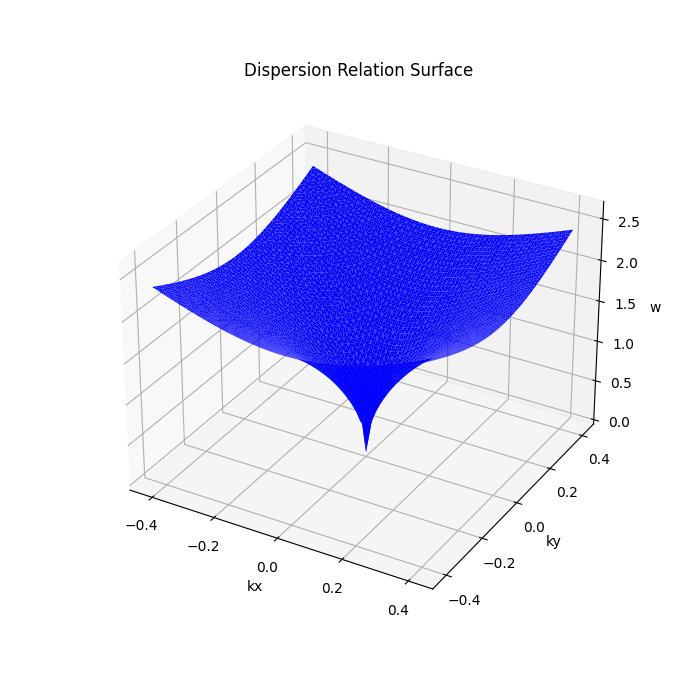

In [88]:
# Create a meshgrid for kx and ky
kx, ky = np.meshgrid(Kx, Ky)

# Assuming Ux is an array with the same shape as kx and ky
Ux_values = Uk[:,0]

# Calculate w values using the function
w_values = w_dr(kx, ky, Ux_values[:, np.newaxis, np.newaxis], 0)

# Flatten the arrays
kx_flat = kx.flatten()
ky_flat = ky.flatten()
w_values_flat = w_values.flatten()

# Plot the function in 3D space
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(kx_flat, ky_flat, w_values_flat, cmap= ListedColormap(['blue']) )#'viridis'

# Set labels
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('w')

plt.title("Dispersion Relation Surface")

# disp_kx, disp_ky, disp_ww = plot_disp_shell(ax, h=1000, z = z, U = U, psi = 0)

# Show the plot
plt.show()


In [89]:
np.max(power_Spectrum)

1580301578.0185962

In [106]:
count_greater_than_big = np.sum(power_Spectrum >= np.max(power_Spectrum)*0.2)

In [107]:
count_greater_than_big

94

In [108]:
indices_greater_than_big = np.where(power_Spectrum >= np.max(power_Spectrum)*0.2)
indices_greater_than_big

(array([409, 412, 419, 419, 420, 426, 427, 428, 428, 430, 431, 432, 432,
        433, 434, 434, 435, 435, 436, 436, 438, 439, 439, 439, 439, 440,
        441, 442, 442, 442, 443, 443, 445, 445, 446, 447, 447, 447, 448,
        449, 450, 451, 452, 453, 459, 459, 466, 734, 741, 741, 747, 748,
        749, 750, 751, 752, 753, 753, 753, 754, 755, 755, 757, 757, 758,
        758, 758, 759, 760, 761, 761, 761, 761, 762, 764, 764, 765, 765,
        766, 766, 767, 768, 768, 769, 770, 772, 772, 773, 774, 780, 781,
        781, 788, 791], dtype=int64),
 array([34, 31, 33, 34, 34, 33, 34, 31, 32, 33, 30, 34, 35, 33, 32, 34, 33,
        34, 31, 34, 34, 31, 33, 34, 34, 33, 32, 32, 34, 34, 31, 35, 32, 34,
        35, 32, 33, 34, 34, 32, 33, 33, 33, 33, 31, 32, 33, 33, 34, 35, 33,
        33, 33, 33, 34, 32, 32, 33, 34, 31, 32, 34, 31, 35, 32, 32, 34, 34,
        33, 32, 32, 33, 35, 32, 32, 35, 32, 33, 32, 34, 33, 31, 32, 36, 33,
        34, 35, 32, 33, 32, 32, 33, 35, 32], dtype=int64),
 array([25, 

In [109]:
points = list(zip(indices_greater_than_big[0], indices_greater_than_big[1], indices_greater_than_big[2]))

# Print the points
print("Points where values are greater than 0.2:")
for point in points:
    print(f"({point[0]}, {point[1]}, {point[2]})")

Points where values are greater than 0.2:
(409, 34, 25)
(412, 31, 25)
(419, 33, 26)
(419, 34, 26)
(420, 34, 26)
(426, 33, 26)
(427, 34, 26)
(428, 31, 27)
(428, 32, 26)
(430, 33, 27)
(431, 30, 27)
(432, 34, 27)
(432, 35, 27)
(433, 33, 27)
(434, 32, 27)
(434, 34, 27)
(435, 33, 27)
(435, 34, 27)
(436, 31, 27)
(436, 34, 27)
(438, 34, 27)
(439, 31, 27)
(439, 33, 27)
(439, 34, 27)
(439, 34, 28)
(440, 33, 27)
(441, 32, 27)
(442, 32, 27)
(442, 34, 27)
(442, 34, 28)
(443, 31, 28)
(443, 35, 28)
(445, 32, 28)
(445, 34, 28)
(446, 35, 28)
(447, 32, 28)
(447, 33, 28)
(447, 34, 28)
(448, 34, 28)
(449, 32, 28)
(450, 33, 28)
(451, 33, 28)
(452, 33, 28)
(453, 33, 28)
(459, 31, 29)
(459, 32, 29)
(466, 33, 29)
(734, 33, 37)
(741, 34, 37)
(741, 35, 37)
(747, 33, 38)
(748, 33, 38)
(749, 33, 38)
(750, 33, 38)
(751, 34, 38)
(752, 32, 38)
(753, 32, 38)
(753, 33, 38)
(753, 34, 38)
(754, 31, 38)
(755, 32, 38)
(755, 34, 38)
(757, 31, 38)
(757, 35, 38)
(758, 32, 38)
(758, 32, 39)
(758, 34, 39)
(759, 34, 39)
(760, 

In [110]:
points
# tiplet indices of each 

[(409, 34, 25),
 (412, 31, 25),
 (419, 33, 26),
 (419, 34, 26),
 (420, 34, 26),
 (426, 33, 26),
 (427, 34, 26),
 (428, 31, 27),
 (428, 32, 26),
 (430, 33, 27),
 (431, 30, 27),
 (432, 34, 27),
 (432, 35, 27),
 (433, 33, 27),
 (434, 32, 27),
 (434, 34, 27),
 (435, 33, 27),
 (435, 34, 27),
 (436, 31, 27),
 (436, 34, 27),
 (438, 34, 27),
 (439, 31, 27),
 (439, 33, 27),
 (439, 34, 27),
 (439, 34, 28),
 (440, 33, 27),
 (441, 32, 27),
 (442, 32, 27),
 (442, 34, 27),
 (442, 34, 28),
 (443, 31, 28),
 (443, 35, 28),
 (445, 32, 28),
 (445, 34, 28),
 (446, 35, 28),
 (447, 32, 28),
 (447, 33, 28),
 (447, 34, 28),
 (448, 34, 28),
 (449, 32, 28),
 (450, 33, 28),
 (451, 33, 28),
 (452, 33, 28),
 (453, 33, 28),
 (459, 31, 29),
 (459, 32, 29),
 (466, 33, 29),
 (734, 33, 37),
 (741, 34, 37),
 (741, 35, 37),
 (747, 33, 38),
 (748, 33, 38),
 (749, 33, 38),
 (750, 33, 38),
 (751, 34, 38),
 (752, 32, 38),
 (753, 32, 38),
 (753, 33, 38),
 (753, 34, 38),
 (754, 31, 38),
 (755, 32, 38),
 (755, 34, 38),
 (757, 3

In [111]:
kx[0,:]

array([-0.41262709, -0.40012324, -0.38761939, -0.37511554, -0.36261169,
       -0.35010784, -0.33760399, -0.32510014, -0.31259628, -0.30009243,
       -0.28758858, -0.27508473, -0.26258088, -0.25007703, -0.23757318,
       -0.22506932, -0.21256547, -0.20006162, -0.18755777, -0.17505392,
       -0.16255007, -0.15004622, -0.13754236, -0.12503851, -0.11253466,
       -0.10003081, -0.08752696, -0.07502311, -0.06251926, -0.05001541,
       -0.03751155, -0.0250077 , -0.01250385,  0.        ,  0.01250385,
        0.0250077 ,  0.03751155,  0.05001541,  0.06251926,  0.07502311,
        0.08752696,  0.10003081,  0.11253466,  0.12503851,  0.13754236,
        0.15004622,  0.16255007,  0.17505392,  0.18755777,  0.20006162,
        0.21256547,  0.22506932,  0.23757318,  0.25007703,  0.26258088,
        0.27508473,  0.28758858,  0.30009243,  0.31259628,  0.32510014,
        0.33760399,  0.35010784,  0.36261169,  0.37511554,  0.38761939,
        0.40012324,  0.41262709])

In [112]:
ky[:,0]

array([-0.41262709, -0.40012324, -0.38761939, -0.37511554, -0.36261169,
       -0.35010784, -0.33760399, -0.32510014, -0.31259628, -0.30009243,
       -0.28758858, -0.27508473, -0.26258088, -0.25007703, -0.23757318,
       -0.22506932, -0.21256547, -0.20006162, -0.18755777, -0.17505392,
       -0.16255007, -0.15004622, -0.13754236, -0.12503851, -0.11253466,
       -0.10003081, -0.08752696, -0.07502311, -0.06251926, -0.05001541,
       -0.03751155, -0.0250077 , -0.01250385,  0.        ,  0.01250385,
        0.0250077 ,  0.03751155,  0.05001541,  0.06251926,  0.07502311,
        0.08752696,  0.10003081,  0.11253466,  0.12503851,  0.13754236,
        0.15004622,  0.16255007,  0.17505392,  0.18755777,  0.20006162,
        0.21256547,  0.22506932,  0.23757318,  0.25007703,  0.26258088,
        0.27508473,  0.28758858,  0.30009243,  0.31259628,  0.32510014,
        0.33760399,  0.35010784,  0.36261169,  0.37511554,  0.38761939,
        0.40012324,  0.41262709])

In [113]:
w

array([[2.33373248, 2.3310624 , 2.32840757, ..., 2.60379696, 2.60641451,
        2.60903394],
       [2.33199843, 2.32932451, 2.32666583, ..., 2.60205522, 2.60467662,
        2.60729989],
       [2.33026567, 2.3275879 , 2.32492537, ..., 2.60031476, 2.60294001,
        2.60556714],
       ...,
       [2.33026567, 2.3275879 , 2.32492537, ..., 2.60031476, 2.60294001,
        2.60556714],
       [2.33199843, 2.32932451, 2.32666583, ..., 2.60205522, 2.60467662,
        2.60729989],
       [2.33373248, 2.3310624 , 2.32840757, ..., 2.60379696, 2.60641451,
        2.60903394]])

In [114]:
w_new = spec3d.w
w_new

array([-3.14159265, -3.13635667, -3.13112068, ...,  3.12588469,
        3.13112068,  3.13635667])

In [115]:
points

[(409, 34, 25),
 (412, 31, 25),
 (419, 33, 26),
 (419, 34, 26),
 (420, 34, 26),
 (426, 33, 26),
 (427, 34, 26),
 (428, 31, 27),
 (428, 32, 26),
 (430, 33, 27),
 (431, 30, 27),
 (432, 34, 27),
 (432, 35, 27),
 (433, 33, 27),
 (434, 32, 27),
 (434, 34, 27),
 (435, 33, 27),
 (435, 34, 27),
 (436, 31, 27),
 (436, 34, 27),
 (438, 34, 27),
 (439, 31, 27),
 (439, 33, 27),
 (439, 34, 27),
 (439, 34, 28),
 (440, 33, 27),
 (441, 32, 27),
 (442, 32, 27),
 (442, 34, 27),
 (442, 34, 28),
 (443, 31, 28),
 (443, 35, 28),
 (445, 32, 28),
 (445, 34, 28),
 (446, 35, 28),
 (447, 32, 28),
 (447, 33, 28),
 (447, 34, 28),
 (448, 34, 28),
 (449, 32, 28),
 (450, 33, 28),
 (451, 33, 28),
 (452, 33, 28),
 (453, 33, 28),
 (459, 31, 29),
 (459, 32, 29),
 (466, 33, 29),
 (734, 33, 37),
 (741, 34, 37),
 (741, 35, 37),
 (747, 33, 38),
 (748, 33, 38),
 (749, 33, 38),
 (750, 33, 38),
 (751, 34, 38),
 (752, 32, 38),
 (753, 32, 38),
 (753, 33, 38),
 (753, 34, 38),
 (754, 31, 38),
 (755, 32, 38),
 (755, 34, 38),
 (757, 3

In [116]:
points[0]

(409, 34, 25)

In [117]:
kx_trip = []
ky_trip = []
w_trip = []

for i in range(len(points)):
    kx_trip.append( kx[0,:] [ points[i][1] ])
    ky_trip.append( ky[:,0] [ points[i][2] ])
    w_trip.append( w_new [  points[i][0] ])

In [118]:
count_greater_than_big/2

47.0

In [119]:
np.array( w_trip )[count_greater_than_big//2:]

array([0.70162236, 0.73827427, 0.73827427, 0.7696902 , 0.77492619,
       0.78016218, 0.78539816, 0.79063415, 0.79587014, 0.80110613,
       0.80110613, 0.80110613, 0.80634211, 0.8115781 , 0.8115781 ,
       0.82205008, 0.82205008, 0.82728607, 0.82728607, 0.82728607,
       0.83252205, 0.83775804, 0.84299403, 0.84299403, 0.84299403,
       0.84299403, 0.84823002, 0.85870199, 0.85870199, 0.86393798,
       0.86393798, 0.86917397, 0.86917397, 0.87440996, 0.87964594,
       0.87964594, 0.88488193, 0.89011792, 0.90058989, 0.90058989,
       0.90582588, 0.91106187, 0.9424778 , 0.94771378, 0.94771378,
       0.9843657 , 1.00007366])

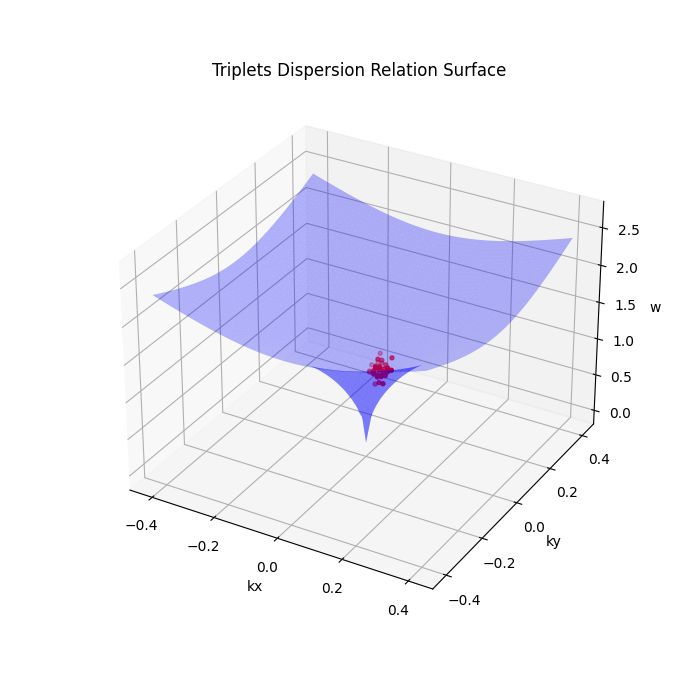

In [122]:
# Create a meshgrid for kx and ky
kx, ky = np.meshgrid(Kx, Ky)

# Assuming Ux is an array with the same shape as kx and ky
Ux_values = Uk[:,0]

# Calculate w values using the function
w_values = w_dr(kx, ky, Ux_values[:, np.newaxis, np.newaxis], 0)

# Flatten the arrays
kx_flat = kx.flatten()
ky_flat = ky.flatten()
w_values_flat = w_values.flatten()

# Plot the function in 3D space
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(kx_flat, ky_flat, w_values_flat, alpha=0.3, cmap= ListedColormap(['blue']) )#'viridis'

# Set labels
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('w')

plt.title("Triplets Dispersion Relation Surface")

ax.scatter( np.array(kx_trip) [count_greater_than_big//2:], np.array(ky_trip) [count_greater_than_big//2:], 
           np.array( w_trip )[count_greater_than_big//2:], color='red', marker='o', s=8)

# disp_kx, disp_ky, disp_ww = plot_disp_shell(ax, h=1000, z = z, U = U, psi = 0)

# Show the plot
plt.show()

In [59]:
np.array(kx_trip) [count_greater_than_big//2:]


array([ 0.01250385, -0.01250385,  0.0250077 , ..., -0.07502311,
       -0.03751155, -0.03751155])

In [60]:
np.array(ky_trip) [count_greater_than_big//2:]

array([0.0250077 , 0.0250077 , 0.0250077 , ..., 0.25007703, 0.26258088,
       0.27508473])

In [125]:
np.array( w_trip )[count_greater_than_big//2:]

array([0.70162236, 0.73827427, 0.73827427, 0.7696902 , 0.77492619,
       0.78016218, 0.78539816, 0.79063415, 0.79587014, 0.80110613,
       0.80110613, 0.80110613, 0.80634211, 0.8115781 , 0.8115781 ,
       0.82205008, 0.82205008, 0.82728607, 0.82728607, 0.82728607,
       0.83252205, 0.83775804, 0.84299403, 0.84299403, 0.84299403,
       0.84299403, 0.84823002, 0.85870199, 0.85870199, 0.86393798,
       0.86393798, 0.86917397, 0.86917397, 0.87440996, 0.87964594,
       0.87964594, 0.88488193, 0.89011792, 0.90058989, 0.90058989,
       0.90582588, 0.91106187, 0.9424778 , 0.94771378, 0.94771378,
       0.9843657 , 1.00007366])

In [188]:
spec3d.Nt = 1200

spec3d.dkx = spec3d.kx[64]-spec3d.kx[63]

In [198]:
def estimate_dispersion_cone(self, h, Umax, kmin=0.04, kmax=0.5, plot_it=False):
        '''
        Estimate dispersion cone. It returns a representation of the dispersion cone where the energy is high enough

        Algorithm: 
        - Pass to polar coordinates 
        - apply dispersion filter to avoid using aliased data etc. 
        - select part of arc where there is energy (>0.1max)
        - define relevant k based on upper and lower bounds of k on the grid (close to kmin, kmax provided)
        - select part of spectrum representing relevant theta and k values 
        - loop through theta:
            - apply gaussian blur
            - find peak of w for for all k of interest along the given angle
        
        

        Parameters:
        -----------
                    input       
                            h       float
                                    waterdepth
                            Umax    float
                                    maximum expected current 
                            kmin    float
                                    lower boundary for wave numbers relevant for defining cone, default 0.04
                            kmax    float
                                    upper boundary for wave numbers relevant for defining cone, default 0.3
                            plot_it bool
                                    if data and cone slice should be shown

                    output:
                            k_rel       array
                                        vector of wave numbers for which the dispersion cone is defined
                            theta_rel  array
                                        vector of azimuth angles for which the dispersion cone is defined
                            w compo. of disp_cone   2d array
                                        angular frequency for each combinatin of wave numbers and angle 
        '''
        w_upper = self.w[self.Nt//2:]
        half_spec = np.flip(self.spectrum()[1:self.Nt//2+1,:,:], axis=0)
        filtered_half_spec = gaussian_filter(half_spec, (0.5,0.3,0.3))

        #k, theta, spec_pol = polar_coordinates.cart2cylindrical(w_upper, self.kx, self.ky, half_spec, Ntheta=100)     
        k, theta, spec_pol = polar_coordinates.cart2cylindrical(w_upper, self.kx, self.ky, filtered_half_spec, Ntheta=100)            
        spec_pol = np.abs(spec_pol)
        
        # dispersion filter

        from radar_tools import dispersion_filter, filter_core
        mask = dispersion_filter.w_k_theta_filter(w_upper, k, theta, Umax, h, w_min=0.6)
        masked_spec_pol = mask*spec_pol
        #masked_spec_pol = spec_pol
        
        # select arc with energy          
        theta_spec = np.sum(np.sum(masked_spec_pol, axis=0), axis=0)        
        rel_indices = np.argwhere(theta_spec>0.2*np.max(theta_spec)).transpose()[0]        
        theta_rel = theta[rel_indices]
        # k_relevant
        k_min_ind = np.argmin(np.abs(k - kmin))
        k_max_ind = np.argmin(np.abs(k - kmax))
        k_rel = k[k_min_ind:k_max_ind+1]
        # empty disp cone
        w_matrix = np.zeros((len(k_rel), len(theta_rel)))
        rel_spec = masked_spec_pol[:,k_min_ind:k_max_ind+1,rel_indices]
        min_dw = 4* np.sqrt(self.dkx*9.81)
        ww, kk = np.meshgrid(w_upper, k_rel, indexing='ij')

        
        def get_U_eff(k):
            Nk = len(k)
            z = np.linspace(-100,0,100)
            U = np.exp(0.5*z) + 0.05
            UU = np.outer(np.ones(Nk), U)
            kk, zz = np.meshgrid(k, z, indexing='ij')
            return 2*k*np.sum(UU*np.exp(2*kk*zz), axis=1) * np.abs(z[1]-z[0])

    
        for i in range(0, len(theta_rel)):
            input_spec = rel_spec[:,:,i]#convolutional_filters.apply_Gaussian_blur(rel_spec[:,:,i])
            max_input_spec = np.outer(np.ones(len(w_upper)), np.max(input_spec, axis=0) )
            # filtering relative to the power along w-axis otherwise spectral noise in the center moves the cone to the center
            input_spec = np.where(input_spec>0.1*max_input_spec, input_spec, 0)
            pow = 1#0.3
            pow2 = 1
            w_peaks = (np.sum(input_spec**pow * ww**pow2, axis=0)/np.sum(input_spec**pow, axis=0))**(1./pow2)
            w_matrix[:,i] = savgol_filter(w_peaks, 31, 3)#w_peaks
            
            if plot_it:
                import pylab as plt
                scaled_2d = spec_pol[:,k_min_ind:k_max_ind,i]/np.max(spec_pol[:,k_min_ind:k_max_ind,i])
                #plotting_interface.plot_k_w_spec(k_rel, w_upper, np.log10(scaled_2d).T, extent=[0.03, 0.35, 0.5, 1.9])
                plotting_interface.plot_k_w_spec(k_rel, w_upper, (input_spec).T, extent=[0.03, 0.35, 0.5, 1.9])
                #plotting_interface.plot(k_rel, w_peaks)
                #plt.plot(k_rel, w_peaks, 'k-.')
                plt.plot(k_rel, savgol_filter(w_peaks, 31, 3), 'w')
                plt.plot(k_rel, np.sqrt(9.81*k_rel) + k_rel*get_U_eff(k_rel)*np.cos(-theta_rel[i]),'--', color='darkorange')
                #plt.xlim(0.055, 0.085)
                #plt.ylim(0.65, 0.95)
                #plotting_interface.savefig('images/disp_rel_est_0_detail_above.pdf'.format(i))
                plotting_interface.show()
        return k_rel, theta_rel, w_matrix

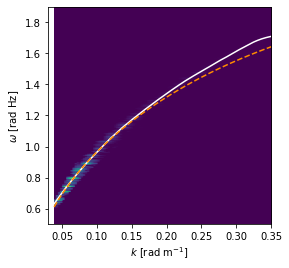

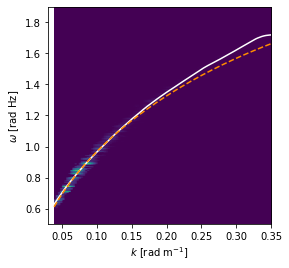

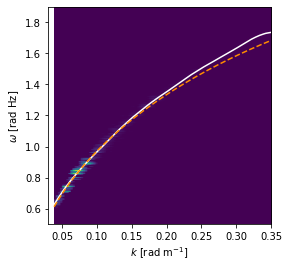

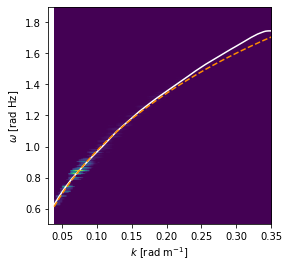

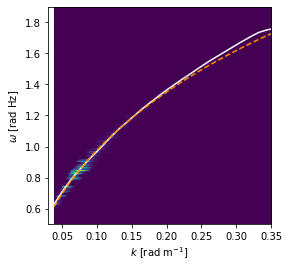

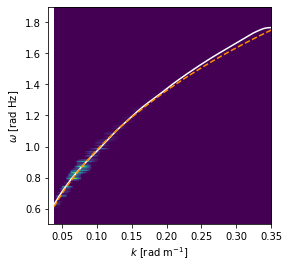

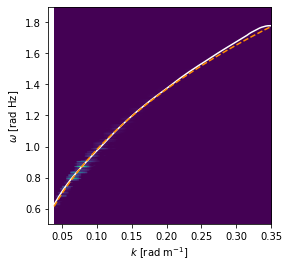

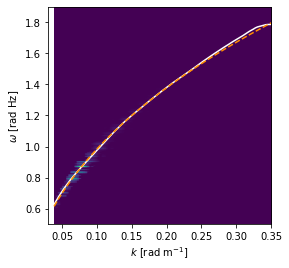

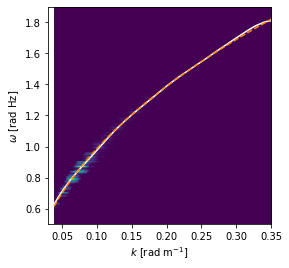

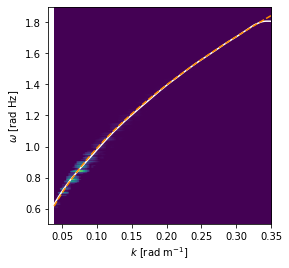

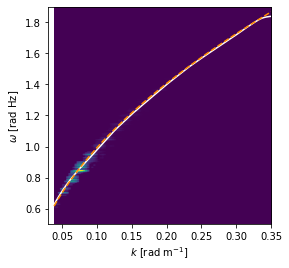

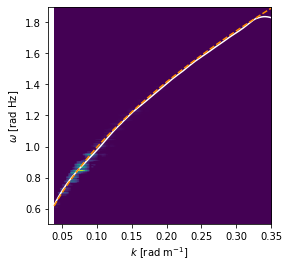

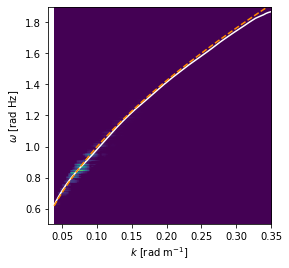

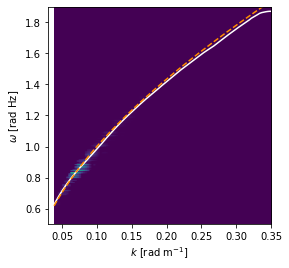

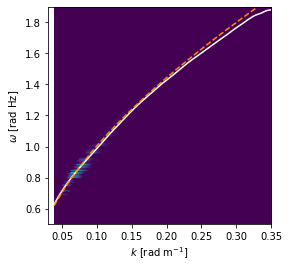

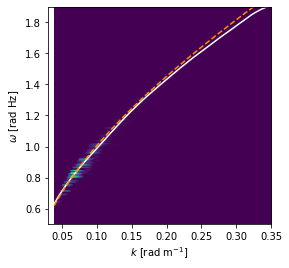

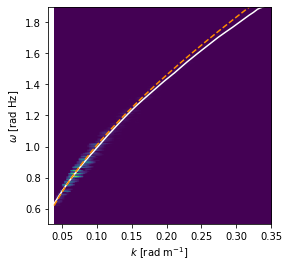

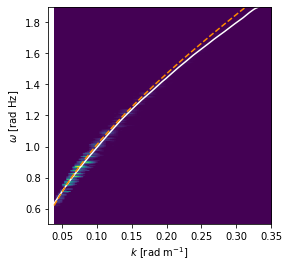

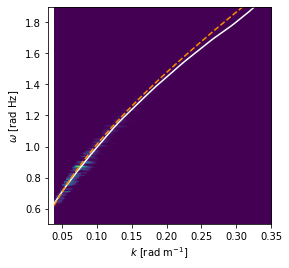

In [208]:
k_rel, theta_rel, w_matrix = estimate_dispersion_cone(spec3d, h=1000, Umax=1, kmin=0.04, kmax=0.5, plot_it=True)

In [205]:
k_rel.shape

(156,)

In [210]:
theta_rel.shape

(19,)

In [213]:
w_matrix.shape

(156, 19)

In [214]:
jx = []
jy = []
wj = []

for i in range(len(theta_rel)):
    
    jx.append( k_rel * np.cos( theta_rel[i] ) )
    jy.append( k_rel * np.sin( theta_rel[i] ) )  
    
    wj.append( w_matrix[:,i] )

In [220]:
wj[0]

array([0.63088358, 0.64991922, 0.66860013, 0.68693613, 0.70493706,
       0.72261273, 0.73997298, 0.75702762, 0.7737865 , 0.79025944,
       0.80645626, 0.82238679, 0.83806087, 0.85348831, 0.86867895,
       0.88364261, 0.8985895 , 0.91304258, 0.9269814 , 0.94087327,
       0.95505513, 0.96925498, 0.98318172, 0.99668147, 1.01010054,
       1.02364258, 1.03740641, 1.05063425, 1.06284833, 1.07488823,
       1.08703556, 1.09937045, 1.1116527 , 1.12349443, 1.13459551,
       1.14564631, 1.15645198, 1.16733754, 1.17815523, 1.18869238,
       1.19924712, 1.2101249 , 1.22078022, 1.23110963, 1.24098597,
       1.25061557, 1.26033085, 1.27041244, 1.28069566, 1.29071142,
       1.30055495, 1.31020253, 1.31964357, 1.32916321, 1.33872248,
       1.34835237, 1.35777908, 1.36676318, 1.37578148, 1.3851412 ,
       1.39456412, 1.40368988, 1.41259726, 1.42118542, 1.42944536,
       1.43765762, 1.44569768, 1.45369333, 1.46163055, 1.46952137,
       1.47715278, 1.48493361, 1.4925758 , 1.50010765, 1.50774

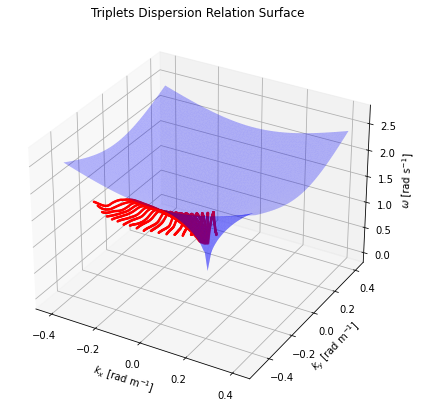

In [507]:
# Create a meshgrid for kx and ky
kx, ky = np.meshgrid(Kx, Ky)

# Assuming Ux is an array with the same shape as kx and ky
Ux_values = Uk[:,0]

# Calculate w values using the function
w_values = w_dr(kx, ky, Ux_values[:, np.newaxis, np.newaxis], 0)

# Flatten the arrays
kx_flat = kx.flatten()
ky_flat = ky.flatten()
w_values_flat = w_values.flatten()

# Plot the function in 3D space
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(kx_flat, ky_flat, w_values_flat, alpha=0.3, cmap= ListedColormap(['blue']) )#'viridis'

# Set labels
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('w')

plt.title("Triplets Dispersion Relation Surface")

for i in range(len(theta_rel)):
    ax.scatter( jx[i], jy[i], wj[i], color='red', marker='o', s=2)
    

disp_kx, disp_ky, disp_ww = plot_disp_shell(ax, h=1000, z = z, U = U, psi = 0)

# Show the plot
plt.show()

# Try to do it for all triplets

In [516]:
kx_new = jx.flatten()
ky_new = jy.flatten()
w_new = wj.flatten()

In [518]:
w_new.shape

(2964,)

In [520]:
def w0(kx, ky):
    return np.sqrt( 9.81 * np.sqrt( kx**2 + ky**2 ) )

In [519]:
# Remember that w0 is constant for all angles

In [492]:
w0 = []
k_new = np.sqrt( jx**2 + jy **2 ) 

for i in range(len(theta_rel)):
    w0.append(np.sqrt( 9.81 * k_new[i] )  )

In [495]:
# Given data
w0 = w0[1]
k = k_new[0][:90]
N1 = np.prod(jx.shape)

In [503]:
import numpy as np
from scipy.optimize import minimize

# Calculate k_i
#k np.sqrt(jx**2 + jy**2)

# Define the objective function to be minimized
def obj_function(U, k, wj, w0):
    return np.sum((wj - w0 - k * U)**2)

# Iterate over each k and find the corresponding U
U_values = []
for ki_value in k:
    # Define the minimization problem
    minimization_result = minimize( obj_function , x0=0, args=(ki_value, wj, w0),method='L-BFGS-B')  
    
    # Store the optimal U value
    U_optimal = minimization_result.x[0]
    U_values.append(U_optimal)

# Print or use U_values as needed
print("Optimal U values for each k:", U_values)


Optimal U values for each k: [21.567741609770547, 20.027189437488826, 18.692043532332903, 17.52379057993971, 16.492979329002292, 15.576702770649806, 14.756876334005598, 14.01903277624684, 13.351459229494234, 12.744575043485465, 12.190463068977248, 11.682527167145363, 11.215225954946165, 10.783871117913014, 10.38446838536576, 10.013594603617372, 9.66829823298839, 9.346021683374559, 9.044537215713493, 8.761895347254773, 8.496383225517821, 8.24648968624384, 8.010875755888714, 7.788351388095146, 7.5778555365500235, 7.378438230220435, 7.189247507749571, 7.009516250516862, 6.838552528183673, 6.675729782589319, 6.520480228017505, 6.372287503343671, 6.2306812159032905, 6.095231517543032, 5.965545774371785, 5.84126358905071, 5.722054133536551, 5.6076130326303035, 5.497659867151949, 5.391935590276332, 5.290200962540669, 5.192234302403309, 5.0978299715500155, 5.006797323456291, 4.91895879520664, 4.834149134038373, 4.75221443664504, 4.673010845327784, 4.596404127012686, 4.522268599237026, 4.450486

Text(0, 0.5, 'U')

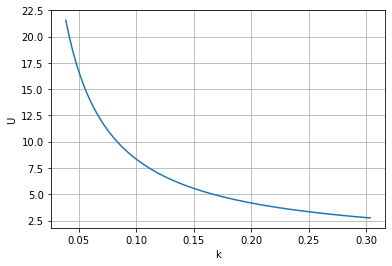

In [498]:
plt.plot(k, np.array( U_values))

plt.grid(True)
plt.xlabel('k')
plt.ylabel('U')

In [455]:
np.prod(jx.shape)

2964

In [411]:
jx.shape

(19, 156)

In [438]:
k

array([[0.03869848, 0.04167528, 0.04465209, ..., 0.49414979, 0.4971266 ,
        0.50010341],
       [0.03869848, 0.04167528, 0.04465209, ..., 0.49414979, 0.4971266 ,
        0.50010341],
       [0.03869848, 0.04167528, 0.04465209, ..., 0.49414979, 0.4971266 ,
        0.50010341],
       ...,
       [0.03869848, 0.04167528, 0.04465209, ..., 0.49414979, 0.4971266 ,
        0.50010341],
       [0.03869848, 0.04167528, 0.04465209, ..., 0.49414979, 0.4971266 ,
        0.50010341],
       [0.03869848, 0.04167528, 0.04465209, ..., 0.49414979, 0.4971266 ,
        0.50010341]])

In [423]:
w0 = []
k = np.sqrt( jx**2 + jy **2 ) 

for i in range(len(theta_rel)):
    w0.append(np.sqrt( 9.81 * k[i] )  )
    

In [424]:
w0 = np.array(w0)
w0.shape

(19, 156)

Text(0.5, 1.0, 'Dispersion Relation w0')

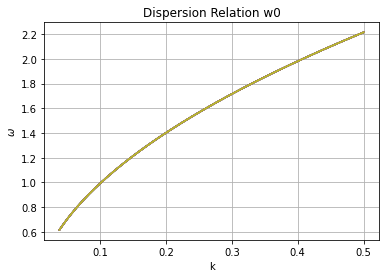

In [437]:
for i in range(len(theta_rel)):
    plt.plot(k[i], w0[i])

plt.grid(True)
plt.xlabel('k')
plt.ylabel('$\omega$')
plt.title("Dispersion Relation w0")

In [425]:
w0

array([[0.6161429 , 0.6394017 , 0.66184364, ..., 2.20172875, 2.2083505 ,
        2.21495246],
       [0.6161429 , 0.6394017 , 0.66184364, ..., 2.20172875, 2.2083505 ,
        2.21495246],
       [0.6161429 , 0.6394017 , 0.66184364, ..., 2.20172875, 2.2083505 ,
        2.21495246],
       ...,
       [0.6161429 , 0.6394017 , 0.66184364, ..., 2.20172875, 2.2083505 ,
        2.21495246],
       [0.6161429 , 0.6394017 , 0.66184364, ..., 2.20172875, 2.2083505 ,
        2.21495246],
       [0.6161429 , 0.6394017 , 0.66184364, ..., 2.20172875, 2.2083505 ,
        2.21495246]])

In [412]:
theta_rel

array([-2.16389108, -2.10073056, -2.03757004, -1.97440952, -1.911249  ,
       -1.84808848, -1.78492796, -1.72176744, -1.65860692, -1.5954464 ,
       -1.53228588, -1.46912536, -1.40596484, -1.34280431, -1.27964379,
       -1.21648327, -1.15332275, -1.09016223, -1.02700171])

In [397]:
jx = np.array(jx)
jy = np.array(jy)
wj = np.array(wj)

In [407]:
jx_flat = jx.flatten()
jy_flat = jy.flatten()
wj_flat = wj.flatten()

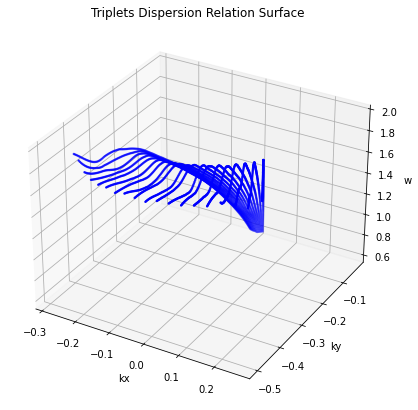

In [409]:
# Plot the function in 3D space
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_trisurf(kx_flat, ky_flat, w_values_flat, alpha=0.3, cmap= ListedColormap(['blue']) )#'viridis'

# Set labels
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('w')

plt.title("Triplets Dispersion Relation Surface")

ax.scatter( jx_flat,  jy_flat, wj_flat, color='blue', marker='o', s=2)
    

#disp_kx, disp_ky, disp_ww = plot_disp_shell(ax, h=1000, z = z, U = U, psi = 0)

# Show the plot
plt.show()

In [392]:
jx_flat = jx.flatten()

AttributeError: 'list' object has no attribute 'flatten'

In [349]:
def plot_disp_relation_and_points_at_theta(spec_theta,  h, z, U, psi):
    '''
    This function finds the relationship between triplets found from spectrum from FFT 
    and the dispersion relation at specific theta. 
    It plots it in the Radial vs Omega Space. 
    '''

    # (2) DISPERSION SURFACE
    axes = fig.add_subplot(111, projection='3d')
    disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h, z, U, psi = 0)
    
    # Convert Dispersion Surface to Polars by first removing mesh grid format
    matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
    disp_r = matrix_disp_r[:,0]
    
    matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
    disp_theta = matrix_disp_theta[0]
    
    nearest_index = np.argmin(np.abs(disp_theta - spec_theta))
    disp_ww_for_theta = disp_ww[:, nearest_index]
    
    plt.plot(disp_r, disp_ww_for_theta, color='grey',zorder=0, label = 'Dispersion Relation at $\Theta$')
    plt.grid(True)
    plt.xlabel('Radial Distance (r)')
    plt.ylabel('$\omega$')
    plt.title("Dispersion Relation vs Triplets in Radial-Frequency Space")
    plt.legend()
    
    return disp_r, disp_ww_for_theta
    
    

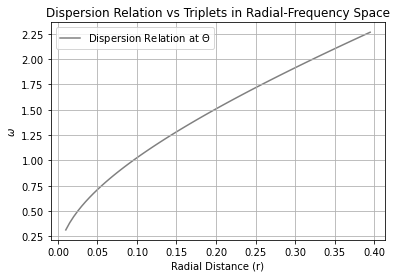

In [350]:
disp_r, disp_ww_for_theta = plot_disp_relation_and_points_at_theta(0, h=1000, z = z, U=U, psi = 0)

In [351]:
theta_rel

array([-2.16389108, -2.10073056, -2.03757004, -1.97440952, -1.911249  ,
       -1.84808848, -1.78492796, -1.72176744, -1.65860692, -1.5954464 ,
       -1.53228588, -1.46912536, -1.40596484, -1.34280431, -1.27964379,
       -1.21648327, -1.15332275, -1.09016223, -1.02700171])

In [352]:
# lets do it at theta = -1.34280431

In [353]:
theta_rel[13]

-1.3428043146477586

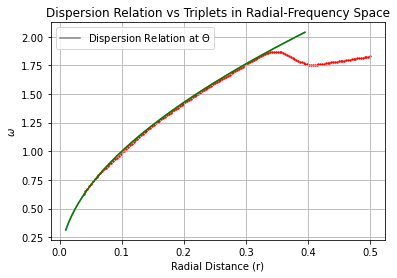

In [384]:
disp_r, disp_ww_for_theta = plot_disp_relation_and_points_at_theta(theta_rel[13], h=1000, z = z, U=U, psi = 0)

plt.scatter(np.sqrt(jx[13]**2+jy[13]**2),wj[13], color = 'red', s = 2)

plt.plot(disp_r, np.sqrt(9.81*disp_r) + + disp_r* optimized_U2,  color = 'green')

In [369]:
k_TRIP = np.sqrt( jx[13]**2+jy[13]**2 )
w_TRIP = wj[13]

In [370]:
k_trip = k_TRIP[:90]
w_trip = w_TRIP[:90]

In [371]:
w_0 = np.sqrt( 9.81 * k_trip )

In [372]:
def obj(U, w_i, w_0, k):
    return (w_i - w_0 - k*U)**2

# Initial guess for U
initial_U = np.zeros(len(k_trip))

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=(w_trip,w_0 ,k_trip))

# Optimized U values
optimized_U1 = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U1)

Optimized U values: [ 0.26532503  0.27674861  0.27781634  0.27036587  0.25603984  0.2362945
  0.2124162   0.18554027  0.1566694   0.12669067  0.09639061  0.0664684
  0.03754727  0.01018431 -0.01512113 -0.0379201  -0.05274096 -0.06758252
 -0.07327342 -0.07145063 -0.06871354 -0.06630149 -0.06104098 -0.04952057
 -0.0326781  -0.01980867 -0.00744188  0.00490921  0.01503607  0.02582821
  0.03358283  0.0408753   0.0460659   0.05041287  0.05558147  0.05754484
  0.0584476   0.0598065   0.06400772  0.06671447  0.06761278  0.06893417
  0.07147065  0.07316791  0.07294107  0.0728793   0.07380149  0.07290134
  0.07078412  0.07006396  0.07163521  0.07546328  0.07777324  0.07929999
  0.08085545  0.08208154  0.08408618  0.08675082  0.08981985  0.09443803
  0.09825779  0.100565    0.10012301  0.09951768  0.10009833  0.10212146
  0.10376513  0.10498369  0.10570412  0.10607341  0.10668878  0.10844106
  0.10876689  0.10732715  0.10436143  0.10164001  0.09911909  0.09843298
  0.10140633  0.10544044  0.10995

Text(0.5, 0, 'k')

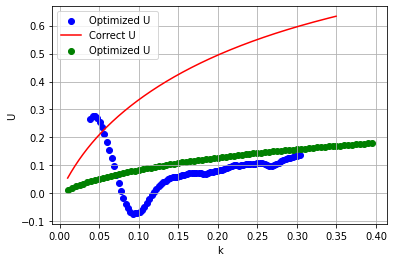

In [379]:
plt.scatter(k_trip, optimized_U1, label='Optimized U ', color='blue')
plt.plot(k, Uk[:,0], label = 'Correct U', color='red')

plt.scatter(disp_r, optimized_U2, label='Optimized U ', color='green')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

In [374]:
disp_r, disp_ww_for_theta

(array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
        0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
        0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
        0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
        0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225, 0.23 ,
        0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 , 0.275,
        0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315, 0.32 ,
        0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355, 0.36 , 0.365,
        0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395]),
 array([0.31334376, 0.38389257, 0.44344376, 0.49598046, 0.54354393,
        0.58734581, 0.6281749 , 0.66657867, 0.70295541, 0.73760557,
        0.77076237, 0.80261116, 0.83330208, 0.86295878, 0.8916845 ,
        0.91956652, 0.94667935, 0.97308725, 0.99884606, 1.02400467,
        1.04860617, 1.07268876, 1.09628653, 1.11942997, 1.14214656,
        1.16446113, 1.18639619, 1.207972

In [375]:
w_0 = np.sqrt( 9.81 * disp_r )

In [376]:
def obj(U, w_i, w_0, k):
    return (w_i - w_0 - k*U)**2

# Initial guess for U
initial_U = np.linspace(0.01, 0.6, len(disp_r))

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=(disp_ww_for_theta, w_0 , disp_r))

# Optimized U values
optimized_U2 = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U2)

Optimized U values: [0.0134294  0.01940081 0.0249564  0.03015195 0.03503399 0.03964145
 0.04400702 0.04815821 0.05211827 0.05590693 0.05954096 0.0630347
 0.06640048 0.06964894 0.07278928 0.07582954 0.07877678 0.08163718
 0.08441626 0.0871189  0.08974949 0.09231199 0.09480995 0.09724663
 0.099625   0.10194778 0.10421748 0.10643643 0.10860677 0.11073053
 0.11280956 0.11484564 0.11684041 0.11879542 0.12071216 0.12259199
 0.12443625 0.12624617 0.12802293 0.12976767 0.13148146 0.13316531
 0.13482021 0.13644709 0.13804684 0.1396203  0.14116831 0.14269163
 0.14419102 0.1456672  0.14712087 0.14855267 0.14996326 0.15135324
 0.1527232  0.15407371 0.15540532 0.15671855 0.15801391 0.15929188
 0.16055294 0.16179753 0.16302611 0.16423908 0.16543687 0.16661985
 0.16778842 0.16894294 0.17008377 0.17121124 0.1723257  0.17342746
 0.17451683 0.17559412 0.17665962 0.17771361 0.17875636 0.17978814]


Text(0.5, 0, 'k')

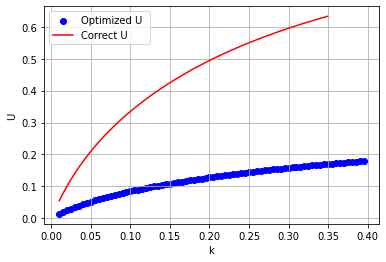

In [377]:
plt.scatter(disp_r, optimized_U2, label='Optimized U ', color='blue')
plt.plot(k, Uk[:,0], label = 'Correct U', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

In [378]:
filtered_half_spec[i,:,:].shape

(66, 66)

In [187]:
spec3d.kx[64]-spec3d.kx[63]

0.012693303650867849

In [ ]:
aa

In [179]:
spec3d.Nt = 1200

In [180]:
spec3d.Nt

1200

In [155]:
spec3d.w[spec3d.Nt//2:].shape

(600,)

In [ ]:
k, theta, spec_pol = polar_coordinates.cart2cylindrical(w_upper, self.kx, self.ky, filtered_half_spec, Ntheta=100)           

In [164]:
half_spec = np.flip(spec3d.spectrum()[1:spec3d.Nt//2+1,:,:], axis=0)
half_spec.T.shape

(66, 66, 600)

In [163]:
filtered_half_spec = gaussian_filter(half_spec, (0.5,0.3,0.3))
filtered_half_spec.shape

(600, 66, 66)

In [177]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [62]:
# slice along kx = 0
zero_indices = np.where( np.array(kx_trip) [47:] ==0 )
zero_indices

(array([  40,   44,   52,   75,   76,  107,  116,  123,  150,  163,  181,
         215,  241,  250,  263,  287,  294,  306,  307,  345,  357,  368,
         379,  388,  399,  400,  408,  409,  420,  421,  436,  437,  448,
         461,  475,  484,  498,  511,  522,  534,  535,  561,  562,  572,
         586,  609,  617,  626,  637,  638,  654,  655,  673,  685,  686,
         701,  702,  712,  713,  729,  730,  742,  754,  763,  772,  781,
         795,  820,  821,  837,  838,  853,  854,  855,  856,  871,  872,
         884,  885,  886,  887,  901,  902,  928,  941,  951,  966,  983,
         984,  985,  986, 1029, 1030, 1031, 1032, 1033, 1051, 1052, 1053,
        1078, 1079, 1080, 1081, 1082, 1083, 1108, 1109, 1110, 1124, 1125,
        1138, 1139, 1140, 1141, 1155, 1156, 1172, 1173, 1193, 1211, 1212,
        1224, 1248, 1249, 1250, 1251, 1281, 1282, 1283, 1284, 1285, 1286,
        1287, 1309, 1310, 1311, 1312, 1333, 1334, 1335, 1336, 1357, 1358,
        1359, 1360, 1376, 1377, 1389, 

In [63]:
ky_sliced = np.array(ky_trip) [47:] [zero_indices]
ky_sliced

array([-0.18755777, -0.18755777, -0.18755777, -0.18755777, -0.17505392,
       -0.17505392, -0.17505392, -0.17505392, -0.16255007, -0.16255007,
       -0.16255007, -0.16255007, -0.15004622, -0.15004622, -0.15004622,
       -0.15004622, -0.15004622, -0.15004622, -0.13754236, -0.13754236,
       -0.13754236, -0.13754236, -0.13754236, -0.13754236, -0.13754236,
       -0.12503851, -0.13754236, -0.12503851, -0.13754236, -0.12503851,
       -0.13754236, -0.12503851, -0.12503851, -0.12503851, -0.12503851,
       -0.12503851, -0.12503851, -0.12503851, -0.12503851, -0.12503851,
       -0.11253466, -0.12503851, -0.11253466, -0.11253466, -0.11253466,
       -0.11253466, -0.11253466, -0.11253466, -0.11253466, -0.10003081,
       -0.11253466, -0.10003081, -0.11253466, -0.11253466, -0.10003081,
       -0.11253466, -0.10003081, -0.11253466, -0.10003081, -0.11253466,
       -0.10003081, -0.10003081, -0.10003081, -0.10003081, -0.10003081,
       -0.10003081, -0.10003081, -0.10003081, -0.08752696, -0.10

In [64]:
w_sliced = np.array(w_trip) [47:] [zero_indices]
w_sliced

array([-1.36135682, -1.35612083, -1.34564885, -1.32994089, -1.32994089,
       -1.30899694, -1.30376095, -1.29852496, -1.282817  , -1.27758101,
       -1.26710904, -1.24616509, -1.23045712, -1.22522113, -1.21998515,
       -1.20427718, -1.1990412 , -1.19380521, -1.19380521, -1.17286126,
       -1.16762527, -1.16238928, -1.15715329, -1.15191731, -1.14668132,
       -1.14668132, -1.14144533, -1.14144533, -1.13620934, -1.13620934,
       -1.13097336, -1.13097336, -1.12573737, -1.12050138, -1.11526539,
       -1.1100294 , -1.10479342, -1.09955743, -1.09432144, -1.08908545,
       -1.08908545, -1.07861348, -1.07861348, -1.07337749, -1.0681415 ,
       -1.05766953, -1.05243354, -1.04719755, -1.04196156, -1.04196156,
       -1.03672558, -1.03672558, -1.03148959, -1.0262536 , -1.0262536 ,
       -1.02101761, -1.02101761, -1.01578162, -1.01578162, -1.01054564,
       -1.01054564, -1.00530965, -1.00007366, -0.99483767, -0.98960169,
       -0.9843657 , -0.97912971, -0.96865773, -0.96865773, -0.96

In [65]:
kx

array([[-0.41262709, -0.40012324, -0.38761939, ...,  0.38761939,
         0.40012324,  0.41262709],
       [-0.41262709, -0.40012324, -0.38761939, ...,  0.38761939,
         0.40012324,  0.41262709],
       [-0.41262709, -0.40012324, -0.38761939, ...,  0.38761939,
         0.40012324,  0.41262709],
       ...,
       [-0.41262709, -0.40012324, -0.38761939, ...,  0.38761939,
         0.40012324,  0.41262709],
       [-0.41262709, -0.40012324, -0.38761939, ...,  0.38761939,
         0.40012324,  0.41262709],
       [-0.41262709, -0.40012324, -0.38761939, ...,  0.38761939,
         0.40012324,  0.41262709]])

In [66]:
kx[:,33]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [67]:
ky[:,33]

array([-0.41262709, -0.40012324, -0.38761939, -0.37511554, -0.36261169,
       -0.35010784, -0.33760399, -0.32510014, -0.31259628, -0.30009243,
       -0.28758858, -0.27508473, -0.26258088, -0.25007703, -0.23757318,
       -0.22506932, -0.21256547, -0.20006162, -0.18755777, -0.17505392,
       -0.16255007, -0.15004622, -0.13754236, -0.12503851, -0.11253466,
       -0.10003081, -0.08752696, -0.07502311, -0.06251926, -0.05001541,
       -0.03751155, -0.0250077 , -0.01250385,  0.        ,  0.01250385,
        0.0250077 ,  0.03751155,  0.05001541,  0.06251926,  0.07502311,
        0.08752696,  0.10003081,  0.11253466,  0.12503851,  0.13754236,
        0.15004622,  0.16255007,  0.17505392,  0.18755777,  0.20006162,
        0.21256547,  0.22506932,  0.23757318,  0.25007703,  0.26258088,
        0.27508473,  0.28758858,  0.30009243,  0.31259628,  0.32510014,
        0.33760399,  0.35010784,  0.36261169,  0.37511554,  0.38761939,
        0.40012324,  0.41262709])

In [68]:
w_values.shape

(680, 67, 67)

In [69]:
def sliced_at_0(ky):
    g = 9.81
    h = 1000
    return np.sqrt( g * np.abs(ky) * np.tanh( h * np.abs(ky)))

In [70]:
ky_sliced

array([-0.18755777, -0.18755777, -0.18755777, -0.18755777, -0.17505392,
       -0.17505392, -0.17505392, -0.17505392, -0.16255007, -0.16255007,
       -0.16255007, -0.16255007, -0.15004622, -0.15004622, -0.15004622,
       -0.15004622, -0.15004622, -0.15004622, -0.13754236, -0.13754236,
       -0.13754236, -0.13754236, -0.13754236, -0.13754236, -0.13754236,
       -0.12503851, -0.13754236, -0.12503851, -0.13754236, -0.12503851,
       -0.13754236, -0.12503851, -0.12503851, -0.12503851, -0.12503851,
       -0.12503851, -0.12503851, -0.12503851, -0.12503851, -0.12503851,
       -0.11253466, -0.12503851, -0.11253466, -0.11253466, -0.11253466,
       -0.11253466, -0.11253466, -0.11253466, -0.11253466, -0.10003081,
       -0.11253466, -0.10003081, -0.11253466, -0.11253466, -0.10003081,
       -0.11253466, -0.10003081, -0.11253466, -0.10003081, -0.11253466,
       -0.10003081, -0.10003081, -0.10003081, -0.10003081, -0.10003081,
       -0.10003081, -0.10003081, -0.10003081, -0.08752696, -0.10

In [71]:
w_sliced

array([-1.36135682, -1.35612083, -1.34564885, -1.32994089, -1.32994089,
       -1.30899694, -1.30376095, -1.29852496, -1.282817  , -1.27758101,
       -1.26710904, -1.24616509, -1.23045712, -1.22522113, -1.21998515,
       -1.20427718, -1.1990412 , -1.19380521, -1.19380521, -1.17286126,
       -1.16762527, -1.16238928, -1.15715329, -1.15191731, -1.14668132,
       -1.14668132, -1.14144533, -1.14144533, -1.13620934, -1.13620934,
       -1.13097336, -1.13097336, -1.12573737, -1.12050138, -1.11526539,
       -1.1100294 , -1.10479342, -1.09955743, -1.09432144, -1.08908545,
       -1.08908545, -1.07861348, -1.07861348, -1.07337749, -1.0681415 ,
       -1.05766953, -1.05243354, -1.04719755, -1.04196156, -1.04196156,
       -1.03672558, -1.03672558, -1.03148959, -1.0262536 , -1.0262536 ,
       -1.02101761, -1.02101761, -1.01578162, -1.01578162, -1.01054564,
       -1.01054564, -1.00530965, -1.00007366, -0.99483767, -0.98960169,
       -0.9843657 , -0.97912971, -0.96865773, -0.96865773, -0.96

Text(0, 0.5, 'w')

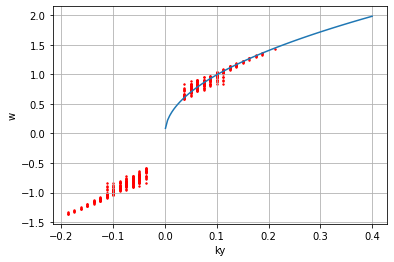

In [72]:
plt.scatter(ky_sliced, w_sliced, color = 'red', s=2)

kv = np.linspace(0.001, 0.4, 100)
plt.plot(kv, sliced_at_0(kv) )

plt.grid(True)
plt.xlabel("ky")
plt.ylabel("w")

#plt.xlim(0.05,0.1)
#plt.ylim(0.6,1)

In [73]:
np.array([sliced_at_0(0.05001541), sliced_at_0(0.06251926), sliced_at_0(0.07502311), sliced_at_0(0.08752696)])

array([0.70046497, 0.78314363, 0.85789085, 0.92662801])

In [74]:
(0.7696902 + 0.77492619 + 0.78016218 + 0.78539816 + 0.80110613)/5

0.782256572

In [75]:
(0.83775804 + 0.84299403 + 0.86393798 + 0.87440996 + 0.89011792)/5

0.861843586

In [76]:
(0.91106187 + 0.94771378)/2

0.9293878250000001

In [77]:
ky_trip = np.array([0.05001541, 0.06251926, 0.07502311, 0.08752696])
w_trip = np.array([0.70046497, 0.782256572, 0.861843586, 0.9293878250000001])

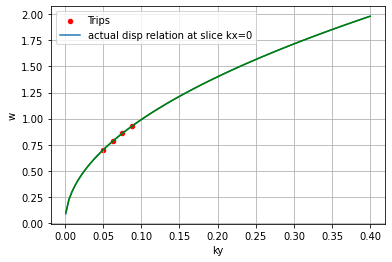

In [78]:
plt.scatter(ky_trip, w_trip, color = 'red', s=20, label="Trips")

kv = np.linspace(0.001, 0.4, 100)
plt.plot(kv, sliced_at_0(kv) , label='actual disp relation at slice kx=0')

plt.grid(True)
plt.xlabel("ky")
plt.ylabel("w")

plt.plot(kv, np.sqrt( 9.81 * kv), color = 'green')

plt.legend()

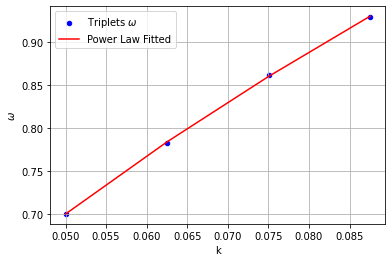

In [79]:
# Use fitting function
def power_law_function(x, a, b, c):
    return a * x**b + c

# Fit the curve
param, covariance = curve_fit(power_law_function, ky_trip, w_trip)
a, b, c = param

# Fitted curve points
k_fit = np.linspace(min(ky_trip), max(ky_trip), len(ky_trip))
y_fit = power_law_function(k_fit, a, b, c)

# Plot data and fitted curve
plt.scatter(ky_trip, w_trip, label='Triplets $\omega$ ', s=20, color='blue')
plt.plot(k_fit, y_fit, label='Power Law Fitted', color='red')

plt.ylabel('$\omega$')
plt.xlabel('k')
plt.grid(True)
plt.legend()

In [80]:
w_0 = np.sqrt( 9.81 * ky_trip)
w_0

array([0.70046497, 0.78314363, 0.85789085, 0.92662801])

In [81]:
def obj(U, w_i, w_0, k):
    return (w_i - w_0 - k*U)**2

# Initial guess for U
initial_U = [0.2, 0.24, 0.26, 0.29]

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=(w_trip, w_0 ,ky_trip))

# Optimized U values
optimized_U = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U)

Optimized U values: [0.02500003 0.01758506 0.07860106 0.06383961]


Text(0.5, 0, 'k')

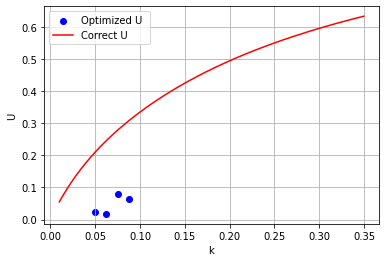

In [82]:
plt.scatter(ky_trip, optimized_U, label='Optimized U ', color='blue')
plt.plot(k, Uk[:,0], label = 'Correct U', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

In [83]:
# when kx = 0 then w_0 is the same as the dispersion surface altered by current 
# need to try another slice where theyre not the same and see if it works to get good velocities

In [791]:
# try remove theta dependence and find velocity at each slice of theta 

# remove it being wrong because at different theta values there are different dispersion relations

In [781]:
kx_trip_large = np.array(kx_trip) [count_greater_than_big//2:]
ky_trip_large = np.array(ky_trip) [count_greater_than_big//2:]
w_trip_large = np.array( w_trip )[count_greater_than_big//2:]

In [783]:
kx_trip_large.shape

(1826,)

Text(0, 0.5, 'w')

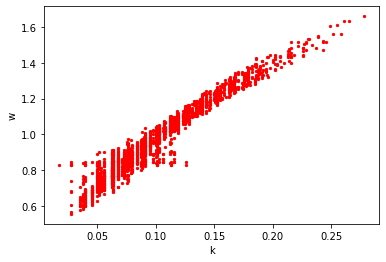

In [789]:
plt.scatter(np.sqrt(kx_trip_large**2 + ky_trip_large**2), w_trip_large, color = 'red', s = 5, label="triplets")

plt.xlabel("k")
plt.ylabel("w")

In [33]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [34]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 1 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.4, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label, color = 'red')
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.5]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles, colors = 'red')#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww

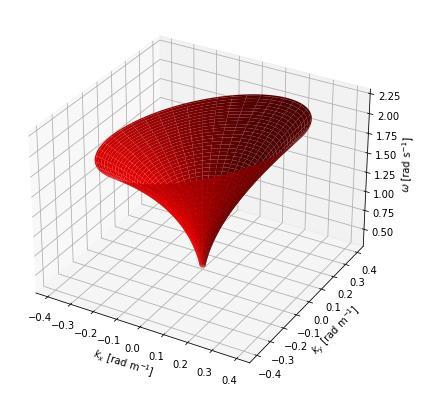

In [35]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h=1000, z = z, U = U, psi = 0)

In [36]:
matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )

In [37]:
disp_r = matrix_disp_r[:,0]

In [38]:
matrix_disp_theta = np.arctan2(disp_ky,disp_kx)

In [39]:
disp_theta = matrix_disp_theta[0]

In [40]:
nearest_index = np.argmin(np.abs(disp_theta - 0))

In [41]:
disp_ww_for_theta = disp_ww[:, nearest_index]

(0.0, 0.36)

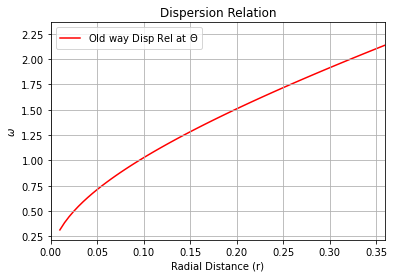

In [42]:
plt.plot(disp_r, disp_ww_for_theta, color='red',zorder=0, label = 'Old way Disp Rel at $\Theta$')
plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega$')
plt.title("Dispersion Relation")
plt.legend()

plt.xlim(0,0.36)

In [43]:
# Define the function w_dr
def w_dr(kx, ky, Ux):
    return np.sqrt(g * np.sqrt(kx**2 + ky**2) * np.tanh(h * np.sqrt(kx**2 + ky**2))) + kx * Ux + ky * Uy

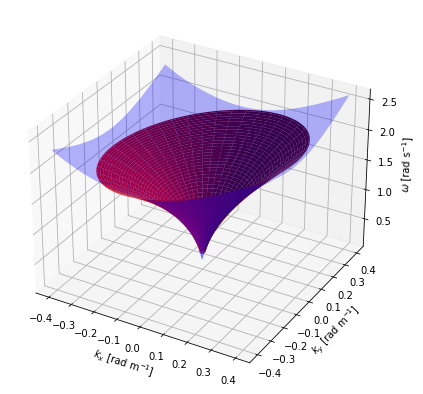

In [44]:
# Given values
g = 9.81
h = 1000 # Adjust this value if needed
Uy = 0.0

# Generate kx, ky values
kx = np.linspace(-0.4, 0.4, 680)
ky = np.linspace(-0.4, 0.4, 680)
kx, ky = np.meshgrid(kx, ky)

# Generate Ux array
Ux = Uk[:,0] # (your provided values) ... , 0.63330752])

# Calculate w values using the w_dr function
w = w_dr(kx, ky, Ux)

# Plot the surface
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(kx, ky, w, alpha = 0.3,  cmap= ListedColormap(['blue'])) #cmap='viridis')

# Set labels
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('w')

disp_kx, disp_ky, disp_ww = plot_disp_shell(ax, h=1000, z = z, U = U, psi = 0)

# Show the plot
plt.show()

In [45]:
kx[0,:].shape

(680,)

In [46]:
np.min( w[0, :] )

1.9660130131156015

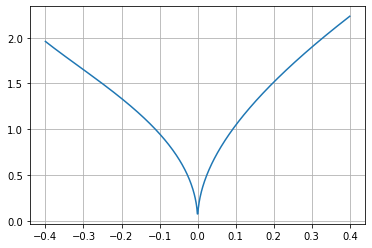

In [47]:
plt.plot(kx[340, :], w[340, :])

plt.grid(True)

In [48]:
w[0,:]

array([2.33373248, 2.3310624 , 2.32840757, 2.32576781, 2.32314293,
       2.32053278, 2.31793718, 2.31535598, 2.31278902, 2.31023613,
       2.30769717, 2.305172  , 2.30266045, 2.3001624 , 2.29767769,
       2.2952062 , 2.29274779, 2.29030233, 2.28786969, 2.28544974,
       2.28304236, 2.28064743, 2.27826484, 2.27589446, 2.27353619,
       2.27118991, 2.26885552, 2.2665329 , 2.26422197, 2.2619226 ,
       2.25963472, 2.25735821, 2.25509299, 2.25283896, 2.25059603,
       2.24836411, 2.24614311, 2.24393296, 2.24173356, 2.23954484,
       2.23736671, 2.23519911, 2.23304194, 2.23089515, 2.22875865,
       2.22663238, 2.22451626, 2.22241023, 2.22031423, 2.21822818,
       2.21615203, 2.21408571, 2.21202916, 2.20998233, 2.20794516,
       2.20591759, 2.20389956, 2.20189103, 2.19989194, 2.19790223,
       2.19592187, 2.19395081, 2.19198899, 2.19003636, 2.1880929 ,
       2.18615854, 2.18423325, 2.182317  , 2.18040972, 2.1785114 ,
       2.17662199, 2.17474145, 2.17286974, 2.17100684, 2.16915